# ADP 실기 28회 머신러닝 
## 학생 결석일수 예측 : 차원축소, 랜포, 인공신경망, LGBM, 보팅
```
- 성별(sex) 바이너리 : ‘F’ - 여성 또는 ‘M’ - 남성
- 나이(age) 숫자: 15 - 22
- 부모님동거여부 (Pstatus) 바이너리: T: 동거 또는 ‘A’: 별거
- 엄마학력(Medu) 숫자 : 0 : 없음, 1 : 초등 교육, 2 : 5-9학년, 3 - 중등 교육 또는 4 - 고등 교육
- 아빠학력(Fedu) 숫자 : 0 : 없음, 1 : 초등 교육, 2 : 5-9학년, 3 - 중등 교육 또는 4 - 고등 교육
- 주보호자(guardian) 명목형 : ‘어머니’, ‘아버지’ 또는 ‘기타’
- 등하교시간(traveltime) 숫자 : 1 : 15분이하, 2 : 15 ~ 30분, 3 : 30분 ~ 1시간, 4 : 1시간 이상
- 학습시간(studytime) 숫자 : 1 : 2시간이하, 2 : 2~5시간, 3 : 5~10시간, 4 : 10시간이상
- 학고횟수(failures) 숫자 : 1, 2, 3 else 4
- 자유시간(freetime) 숫자 : 1(매우 낮음), 2, 3, 4, 5(매우 높음)
- 가족관계(famrel) 숫자 : 1(매우 나쁨), 2, 3, 4, 5(우수)
```

- 1-1) 데이터 EDA & 차원축소가 필요한지?
- 1-2) 1-1에서 찾은 문제 파악후 처리하기
- 1-3) 과적합 문제가 있다고 가정하고 해결하는 방법 2가지 이상 제시/실행/결과

</br>

- 2-1) 랜덤포레스트, 인공신경망(neuralnetwork), LightGBM 모델링 수행 후 f1-score 비교
- 2-2) Soft-voting, Hard-voting 수행 후 f1-score 비교
- 2-3) 5가지 방법 중 최적의 방법 선택 및 이유 설명
- 2-4) 만든 모델을 학교 정보시스템에서 활용하려면 어떻게 해야하는지 적고 설명

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메세지 숨기기
import warnings
warnings.filterwarnings("ignore")

## 1-1) 데이터 EDA & 차원축소가 필요한지?

In [26]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem1.csv')
df.head()

,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
0,F,18.0,A,4,4,mother,2,2.0,0,4,3.0,6
1,F,17.0,T,1,1,father,2,1.0,0,5,3.0,4
2,F,15.0,T,1,1,mother,2,1.0,3,4,3.0,10
3,F,15.0,T,2,4,mother,3,1.0,0,3,2.0,2
4,F,NaN,T,3,3,father,2,1.0,0,4,3.0,4


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         395 non-null    object 
 1   age         392 non-null    float64
 2   Pstatus     395 non-null    object 
 3   Fedu        395 non-null    int64  
 4   Medu        395 non-null    int64  
 5   guardian    395 non-null    object 
 6   studytime   395 non-null    int64  
 7   traveltime  392 non-null    float64
 8   failures    395 non-null    int64  
 9   famrel      395 non-null    int64  
 10  freetime    390 non-null    float64
 11  absences    395 non-null    int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 37.2+ KB


#### 칼럼의 특성을 살펴봤을 때 sex(성별), Pstatus(부모님 동거여부), guardian(주보호자)가 범주형 변수임을 확인할 수 있다.
#### 모델링을 위해 추후 인코딩을 고려해볼 수 있다.

In [28]:
df.describe()

,age,Fedu,Medu,studytime,traveltime,failures,famrel,freetime,absences
count,392.000000,395.000000,395.000000,395.000000,392.000000,395.000000,395.000000,390.000000,395.000000
mean,16.698980,2.521519,2.749367,2.035443,1.446429,0.334177,3.944304,3.233333,5.708861
std,1.279865,1.088201,1.094735,0.839240,0.695022,0.743651,0.896659,1.000985,8.003096
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,0.000000
50%,17.000000,2.000000,3.000000,2.000000,1.000000,0.000000,4.000000,3.000000,4.000000
75%,18.000000,3.000000,4.000000,2.000000,2.000000,0.000000,5.000000,4.000000,8.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,75.000000


#### Age 변수의 경우, 기초통계량 결과를 봤을 때 큰 이상이 없어보인다. '학생'의 데이터임을 감안했을 때에도 특별한 이상이 없다고 판단했다.

In [29]:
df.isnull().sum() # 실제 28회 후기에는 결측치가 존재하지 않았다고 함

sex           0
age           3
Pstatus       0
Fedu          0
Medu          0
guardian      0
studytime     0
traveltime    3
failures      0
famrel        0
freetime      5
absences      0
dtype: int64

#### 결측치 확인 결과, traveltime 변수와 freetime 변수에 각각 3, 5개의 결측치가 존재함을 알 수 있었다.

In [30]:
df["absences"].value_counts()

0     115
2      65
4      53
6      31
8      22
10     17
14     12
12     12
3       8
16      7
7       7
5       5
18      5
20      4
11      3
9       3
13      3
15      3
22      3
1       3
38      1
30      1
40      1
23      1
19      1
28      1
75      1
21      1
24      1
56      1
26      1
54      1
25      1
17      1
Name: absences, dtype: int64

In [31]:
# 시험 상황에 비슷하게 값 변형 (임의)
# 실제 28회 후기에는 target 값이 0~4 (5개)

# 변경할 숫자 범위 지정
new_values = list(range(5))

# 0~4가 아닌 다른 숫자들에 대해 임의적으로 매핑
other_values = df.loc[~df["absences"].isin(new_values), "absences"].unique()
mapping_dict = {value: np.random.choice(new_values) for value in other_values}

# absences 열에 매핑 적용하여 값 변경
df["absences"] = df["absences"].replace(mapping_dict)

print(df["absences"].value_counts())

0    135
2    104
4     77
3     53
1     26
Name: absences, dtype: int64


### 수치형 변수 분포 시각화

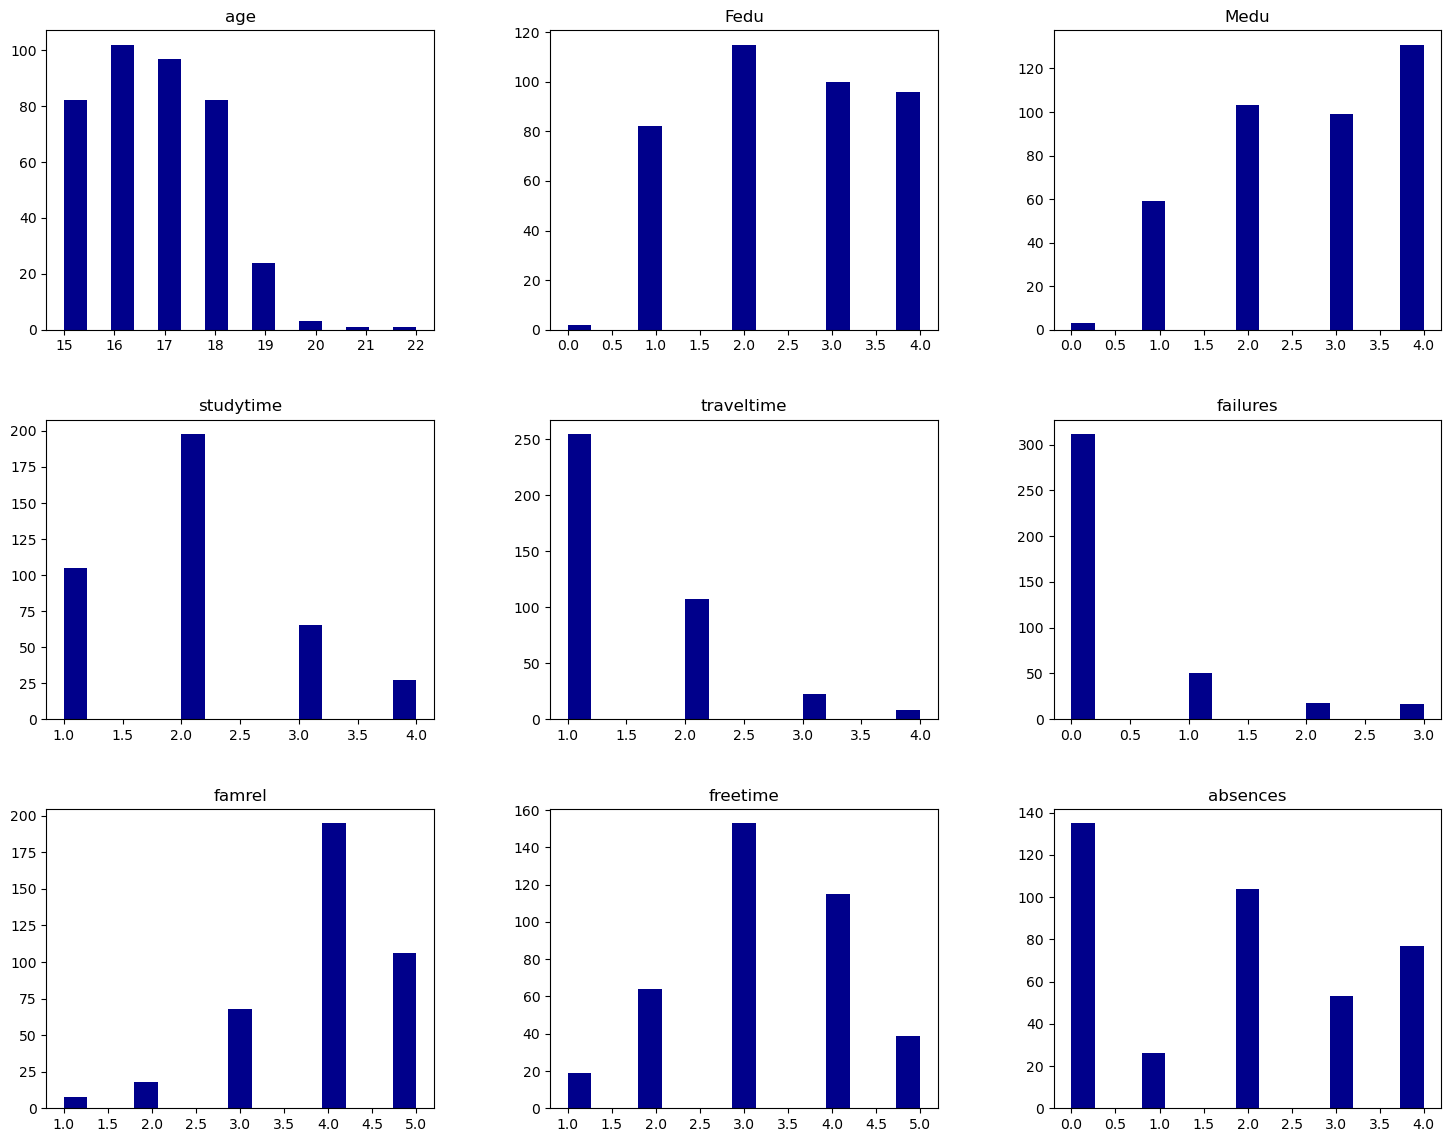

In [34]:
df.hist(bins=15, color='darkblue', figsize=(18,14), grid=False)
plt.show()

### 범주형 변수 시각화

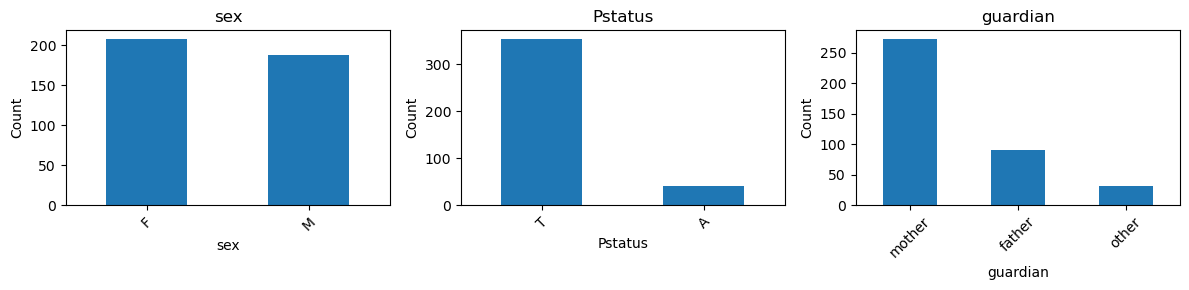

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 프레임에서 범주형 변수 선택
categorical_vars = df.select_dtypes(include=['object']).columns

# 범주형 변수에 대한 barplot 그리기
fig, axes = plt.subplots(1, len(categorical_vars), figsize=(12, 3))

for i, var in enumerate(categorical_vars):
    ax = axes[i]
    df[var].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(var)
    ax.set_xlabel(var)
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # 라벨들의 각도 조절

plt.tight_layout()
plt.show()

### 이상치 탐색

### 상관관계 시각화

<AxesSubplot:>

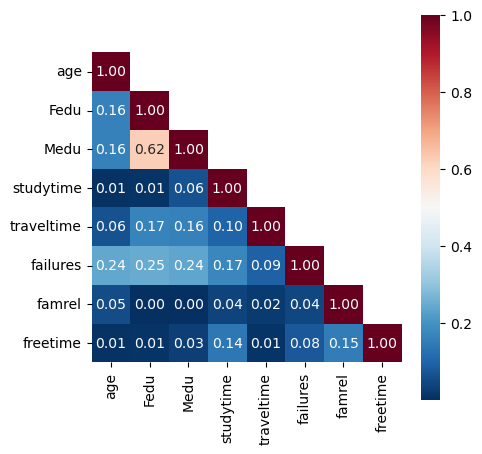

In [45]:
# 상관관계 시각화 : 히트맵
plt.figure(figsize=(5, 5))

# corr matrix 생성
corr_matrix = df.drop(['absences'], axis=1).corr().abs() # .abs() 절댓값 기준

# 상삼각행렬 반환
up_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)

sns.heatmap(corr_matrix, mask=up_mask, annot=True, 
            fmt='.2f', square=True, cmap='RdBu_r')

#### 히트맵 시각화 결과, 변수 간 상관관계가 다소 높아보이는 변수가 존재하지 않다고 판단했다. 
#### 변수 간 상관관계가 높다면 다중공선성이 발생해 예측 성능에 문제를 일으킬 수 있으므로,  추후 차원축소나 변수 선택법 등의 방법을 고려해야한다. 
#### 하지만 본 데이터에서는 문제가 우려되지 않으므로, 차원축소가 크게 필요하지 않다고 판단했다.

- 소희님 답변



* 데이터 EDA 결과 
    * 총 데이터 수는 395개 이며 33개의 변수들이 있음
    * 종속변수는 absences로 범주가 5개에 대한 예측을 수행하야 함 
    * 결측치나 중복값은 없었음
    * 모델 성능을 높이기 위해 yes, no 와 같은 데이터들은 1,0으로 mapping
    * 그외 범주형 변수들은 더미변수 처리 
    * 상관관계가 높은 컬럼 G1,2,3 다중공선성 우려가 있어 분포가 고른 G3를 제외하고 제거함
* 차원축소 필요
    * 범주형 데이터를 더미변수화하면 변수들이 더 많아지기 때문에 모델의 복잡도가 증가할 것
* 기타문제
    * 종속변수가 클래스 별 데이터 불균형이 있음 이는 데이터가 많은 쪽만 예측 결과가 잘 나올 것
    * 클래스 불균형에 적합한 f1-score로 평가하는 것이 적합해보임m

## 1-2) 1-1에서 찾은 문제 파악후 처리하기

### 결측치 처리

위에서 결측치 확인 결과, traveltime 변수와 freetime 변수에 각각 3, 5개의 결측치가 존재함을 알 수 있었으므로 결측치를 처리해준다.

### 범주형 변수 인코딩

## 1-3) 과적합 문제가 있다고 가정하고 해결하는 방법 2가지 이상 제시/실행/결과
- 데이터셋 분리
- 랜덤
- 층화추출
?

## 2-4) 만든 모델을 학교 정보시스템에서 활용하려면 어떻게 해야하는지 적고 설명
핸즈온 머신러닝 책 뒷부분에 deployment 부분 펼쳐두고 거의 똑같이 따라 치면서 중간중간 적당히 말 되는 거 썼던 것 같습니다. API 구현해야 한다 / 계속 새 데이터 들어오니 가중치 업데이트 해야 한다 / 유저에게 신속한 예측결과 제공 위해 시간효율성으로 적극적으로 고려해야 한다 / 데이터 쌓이면 과적합 방지 위해서 모델 조금 경량화 해도 괜찮다 등등...

---

* 실제 시험에 나온 데이터를 kaggle에서 찾아 변형
    - kaggle : https://www.kaggle.com/datasets/dipam7/student-grade-prediction
* 그러나 아래 데이터의 컬럼수나 종속변수 분포가 변형되어 출제
    * 결석률 예측 -> 0~4
* PCA 및 모델 정확도가 잘 나오지 않아 결과값보다는 문제 풀이 방법 위주로 참고 

Reference
- https://coding-law.tistory.com/68